

# Compute and visualize ERDS maps

This example calculates and displays ERDS maps of event-related EEG data.
ERDS (sometimes also written as ERD/ERS) is short for event-related
desynchronization (ERD) and event-related synchronization (ERS)
:footcite:`PfurtschellerLopesdaSilva1999`. Conceptually, ERD corresponds to a
decrease in power in a specific frequency band relative to a baseline.
Similarly, ERS corresponds to an increase in power. An ERDS map is a
time/frequency representation of ERD/ERS over a range of frequencies
:footcite:`GraimannEtAl2002`. ERDS maps are also known as ERSP (event-related
spectral perturbation) :footcite:`Makeig1993`.

In this example, we use an EEG BCI data set containing two different motor
imagery tasks (imagined hand and feet movement). Our goal is to generate ERDS
maps for each of the two tasks.

First, we load the data and create epochs of 5s length. The data set contains
multiple channels, but we will only consider C3, Cz, and C4. We compute maps
containing frequencies ranging from 2 to 35Hz. We map ERD to red color and ERS
to blue color, which is customary in many ERDS publications. Finally, we
perform cluster-based permutation tests to estimate significant ERDS values
(corrected for multiple comparisons within channels).


## ERDS 맵 계산 및 시각화
- EEG 데이터를 기반으로 ERDS 맵을 계산하고 시각화하는 과정을 보여준다.
- ERDS는 event-related desynchronization (ERD) 와 event-related synchronization (ERS) 의 약자로, 두 현상을 합쳐 ERD/ERS 라고도 한다

[개념]
- ERD는 특정 주파수 대역에서의 전력 감소(즉, 동기화가 줄어듦) 의미
- ERS는 특정 주파수 대역에서의 전력 증가(즉, 동기화가 증가함) 의미
- -> ERDS 맵은 여러 주파수에 걸친 ERD/ERS를 시간-주파수 영역에서 시각화

[이 예제는,,]
- 손과 발의 움직임을 상상하는 두 가지 모터 이미저리(motor imagery) 작업이 포함된 EEG 기반 BCI 데이터셋을 사용한다.
- 목표는 각 작업에 대해 ERDS 맵을 생성하는 것이다.

[먼저,]
- 데이터를 불러오고, 길이 5초의 에포크(epoch) 로 분할한다.
- 데이터셋에는 여러 EEG 채널이 포함되어 있으나, 여기서는 C3, Cz, C4 세 채널만을 사용한다.
- 분석 주파수는 2Hz부터 35Hz까지로 설정한다.

[그 후,]
- ERD는 일반적으로 빨간색으로,
- ERS는 파란색으로 시각화되는데, 이는 많은 ERDS 논문에서 사용하는 관례이다.
- 마지막으로, 클러스터 기반 순열 검정 (cluster-based permutation tests) 을 수행하여, 채널 내 다중 비교에 대해 보정된 유의미한 ERDS 값을 추정한다.

In [ ]:
# Authors: Clemens Brunner <clemens.brunner@gmail.com>
#          Felix Klotzsche <klotzsche@cbs.mpg.de>
#
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

As usual, we import everything we need.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.stats import permutation_cluster_1samp_test as pcluster_test

First, we load and preprocess the data. We use runs 6, 10, and 14 from
subject 1 (these runs contains hand and feet motor imagery).
- 먼저 데이터를 로드하고 전처리합니다.
- 피사체 1의 6번, 10번, 14번 실행(이 실행에는 손과 발의 운동 이미지가 포함되어 있습니다)을 사용합니다.


In [ ]:
# eegbci.load_data(...)는 BCI2000 모터 이미저리 데이터셋에서 특정 참가자의 EEG 데이터를 불러오는 함수
# runs=(6, 10, 14)는 해당 피험자의 손(hands) 및 발(feet) 움직임 상상 작업이 포함된 3개의 런(Run) 데이터를 요청
# run 6: left hand
# run 10: right hand
# run 14: feet
names = eegbci.load_data(subject=1, runs=(6, 10, 14))

# read_raw_edf(f, preload=True)는 각 파일 f를 EDF 형식으로 읽어오고, 메모리로 미리 로드한다.
# [read_raw_edf(f, preload=True) for f in fnames]는 위에서 불러온 파일 리스트 fnames를 순회하면서 모두 읽는다.
# concatenate_raws(...)는 이 읽은 EDF 파일들을 하나의 Raw 객체로 결합(concatenate) 한다.
# 즉, 세 개의 런(run)이 하나의 긴 EEG 기록으로 합쳐진다.
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])

# 일부 채널 이름에는 "C3.", "Cz."처럼 이름 끝에 점(dot)이 붙어 있을 수 있다.
# 이 줄은 채널 이름 끝의 점(.)을 제거해서 "C3", "Cz"처럼 정리된 이름으로 바꿔준다.
raw.rename_channels(lambda x: x.strip("."))  # remove dots from channel names

# 이 데이터에는 이벤트 정보가 T1, T2와 같은 코드로 들어 있는데,
# 이 줄은 T1이라는 주석(annotation)을 "hands"로, T2를 "feet"으로 더 해석하기 쉬운 이름으로 바꾸는 작업이다.
# 즉, 이후 분석에서 'hands'와 'feet'이라는 문자열을 보고 어떤 작업인지 바로 알 수 있게 한다.
# rename descriptions to be more easily interpretable
raw.annotations.rename(dict(T1="hands", T2="feet"))

C:\Users\idaeu\AppData\Local\Temp\ipykernel_20716\1872269082.py:1: FutureWarning: The ``subject`` parameter is deprecated and will be removed in version 1.9. Use the ``subjects`` parameter (note the `s`) to suppress this warning.
  fnames = eegbci.load_data(subject=1, runs=(6, 10, 14))


Extracting EDF parameters from C:\Users\idaeu\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\idaeu\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\idaeu\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


<Annotations | 94 segments: BAD boundary (2), EDGE boundary (2), T0 (45), ...>

Now we can create 5-second epochs around events of interest.

- 관심있는 이벤트들을 중심으로 5초의 에포크 생성


#### 손’과 ‘발’ 움직임 상상 작업이 포함된 이벤트들 중심으로, -1초~4초 구간의 EEG 데이터를 자르고, C3, Cz, C4 채널만 선택해서 Epochs 객체로 만들어주는 단계

In [ ]:
# EEG 데이터를 시간 창으로 잘라서 에포크로 만드는 단계

# 시간 창의 시작과 끝을 정의함.
# 즉, 이벤트 발생 시점을 기준으로 -1초부터 +4초까지의 데이터를 사용할 예정임.
# 하지만 밑의 코드에서는 이 값에 약간의 여유를 줘서 tmin - 0.5, tmax + 0.5 만큼 확장하고 있음 → 이유는 필터링 시 경계 왜곡을 줄이기 위해서다.
tmin, tmax = -1, 4

# 이벤트 ID와 조건 이름을 연결하는 딕셔너리임.
# BCI2000 데이터셋에서는:
#   "hands" 작업이 event_id=2
#   "feet" 작업이 event_id=3
# 이는 나중에 '어떤 이벤트가 어떤 작업을 나타내는지' 명확히 하도록 도와줌.
event_ids = dict(hands=2, feet=3)  # map event IDs to tasks

# EEG 데이터를 각 이벤트를 기준으로 에포크로 자르는 핵심 단계
epochs = mne.Epochs(
    raw,                        # 원시 EEG 데이터 (Raw 객체)
    event_id=["hands", "feet"], # 사용할 이벤트 이름들
    tmin=tmin - 0.5,            # 이벤트 전 1.5초부터
    tmax=tmax + 0.5,            # 이벤트 후 4.5초까지 → 총 6초짜리 epoch 생성
    picks=("C3", "Cz", "C4"),   # 사용할 채널 선택 → motor imagery 분석에 주요한 채널
    baseline=None,              # 베이스라인 정규화는 하지 않음
    preload=True,               # 메모리로 미리 불러옴
)

Used Annotations descriptions: [np.str_('T0'), np.str_('feet'), np.str_('hands')]
Ignoring annotation durations and creating fixed-duration epochs around annotation onsets.
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 961 original time points ...
0 bad epochs dropped



Here we set suitable values for computing ERDS maps. Note especially the
``cnorm`` variable, which sets up an *asymmetric* colormap where the middle
color is mapped to zero, even though zero is not the middle *value* of the
colormap range. This does two things: it ensures that zero values will be
plotted in white (given that below we select the ``RdBu`` colormap), and it
makes synchronization and desynchronization look equally prominent in the
plots, even though their extreme values are of different magnitudes.

- 여기에서는 ERDS 맵을 계산하기에 적절한 값들을 설정한다.
- 특히 주목할 것은 cnorm 변수인데, 이는 비대칭 색상 맵(colormap) 을 설정하는 역할을 한다.
- 이때 색상 맵의 범위에서 0이 중간값이 아니더라도, 0의 값이 색상 맵의 중앙 색상(흰색)에 대응되도록 설정된다.
- 이 설정은 두 가지 효과를 가진다:
    - 1. 아래에서 RdBu 색상 맵을 사용할 것이므로, 값이 0인 지점은 흰색으로 시각화된다.
    - 2. 동기화(ERS) 와 비동기화(ERD) 의 극단적인 값들이 서로 다른 크기를 가질지라도, 시각적으로는 동등한 강조 효과(equal prominence) 를 갖도록 만든다.
- 즉, ERD/ERS의 시각적 균형을 유지하고, 0을 기준점으로 명확하게 표현할 수 있도록 도와주는 설정이다.

#### ERDS 맵 계산 및 시각화를 위한 파라미터 설정

In [4]:
# 분석할 주파수 범위를 설정함.
# np.arange(2, 36)은 2Hz부터 35Hz까지 (정수로) 포함된 주파수 배열을 생성.
# 이 범위는 일반적으로 델타~감마 이하 대역을 커버하며, 모터 이미저리와 관련된 알파(8–12Hz), 베타(13–30Hz) 대역을 포함함.
freqs = np.arange(2, 36)  # frequencies from 2-35Hz

# ERDS 값을 시각화할 때 사용할 색상 스케일의 최소값과 최대값 설정.
#   vmin = -1: ERD (감소) 의 최대치
#   vmax = 1.5: ERS (증가) 의 최대치
# 이 범위 내에서 값이 색상으로 매핑됨 (예: RdBu 컬러맵 기준으로 파랑은 증가, 빨강은 감소).
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot

# 베이스라인 구간을 -1초부터 0초까지로 설정함.
# 이 구간은 이벤트 발생 이전의 안정 상태로 간주되며, 이후 구간에서의 전력 변화(ERD/ERS)를 상대적으로 계산할 기준이 됨.
baseline = (-1, 0)  # baseline interval (in s)

# TwoSlopeNorm은 비대칭 색상 정규화(norm) 을 설정하는 함수.
# 핵심은:
#   vmin = -1, vcenter = 0, vmax = 1.5
#   즉, 0은 중간값(center)이지만, vmin과 vmax는 대칭이 아님.
#   덕분에 0의 값은 흰색으로 시각화되고,
#   ERD(감소)는 빨강 계열, ERS(증가)는 파랑 계열로 표시되며, 값의 크기 차이에 관계없이 시각적으로 동등한 강조가 이루어짐
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

# 클러스터 기반 순열 통계 검정에 전달할 옵션 값들을 정의
# n_permutations=100: **순열 검정(permutation test)**에서 사용할 순열의 개수. / 많을수록 정밀도 증가, 계산 비용도 증가.
# step_down_p=0.05: 단계별 p-value 임계값. 클러스터가 통계적으로 유의미하다고 판단되는 기준.
# seed=1: 랜덤성을 제어하기 위한 시드(seed). 결과 재현 가능성을 높임.
# buffer_size=None: 내부 버퍼 설정 (기본값 사용).
# out_type="mask": 결과를 boolean mask 형식으로 반환 (유의미한 구간만 True).
kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test

Finally, we perform time/frequency decomposition over all epochs.

- 마지막으로, 우리는 모든 시대에 걸쳐 시간/주파수 분해 수행

#### EEG의 ERDS (Event-Related Desynchronization/Synchronization) 분석을 위해 시간-주파수 해석(TFR)을 수행하고, 통계적으로 유의미한 변화를 시각화하는 전 과정을 포함

Applying baseline correction (mode: percent)
Using a threshold of 1.724718
stat_fun(H1): min=-8.552076155477078 max=3.1832308002458696
Running initial clustering …
Found 80 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.724718
stat_fun(H1): min=-8.552076155477078 max=3.1832308002458696
Running initial clustering …
Found 67 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.724718
stat_fun(H1): min=-4.528367198129923 max=3.7064219374431913
Running initial clustering …
Found 88 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.724718
stat_fun(H1): min=-4.528367198129923 max=3.7064219374431913
Running initial clustering …
Found 58 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.724718
stat_fun(H1): min=-6.58158928969641 max=3.346448151996899
Running initial clustering …
Found 67 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.724718
stat_fun(H1): min=-6.58158928969641 max=3.346448151996899
Running initial clustering …
Found 69 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied


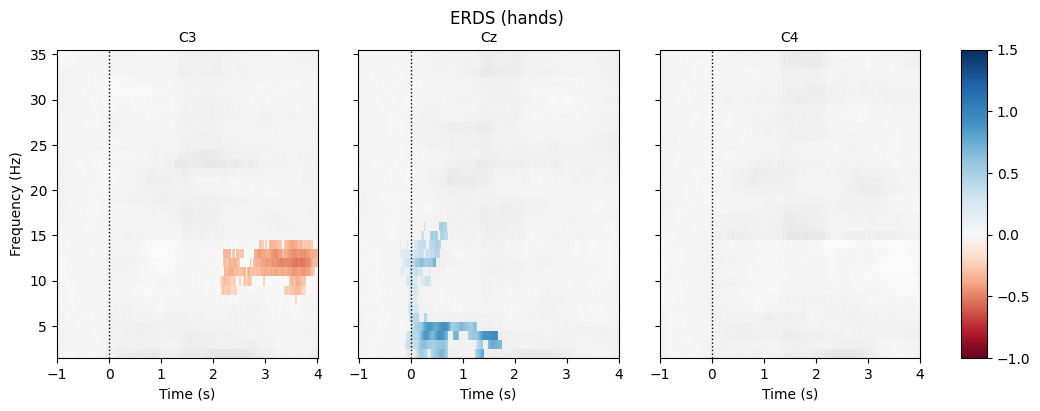

Using a threshold of 1.713872
stat_fun(H1): min=-3.754759498497247 max=3.3607039428313774
Running initial clustering …
Found 71 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.713872
stat_fun(H1): min=-3.754759498497247 max=3.3607039428313774
Running initial clustering …
Found 80 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.713872
stat_fun(H1): min=-4.992503139561787 max=5.416450269990025
Running initial clustering …
Found 103 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.713872
stat_fun(H1): min=-4.992503139561787 max=5.416450269990025
Running initial clustering …
Found 67 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.713872
stat_fun(H1): min=-6.0443399919782985 max=4.0704437822715684
Running initial clustering …
Found 92 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.713872
stat_fun(H1): min=-6.0443399919782985 max=4.0704437822715684
Running initial clustering …
Found 51 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied


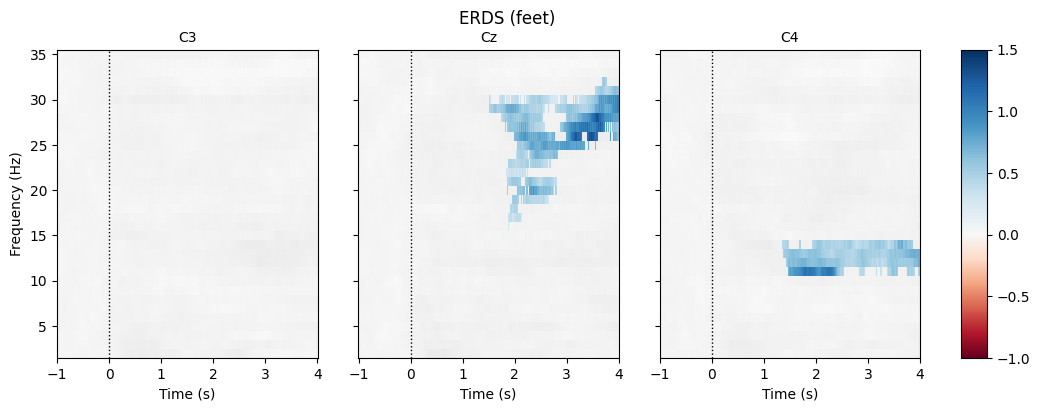

In [ ]:
# 1. 시간-주파수 변환 (TFR: Time-Frequency Representation)
tfr = epochs.compute_tfr(   # epochs.compute_tfr(...): 에포크 데이터를 시간-주파수 도메인으로 변환
    method="multitaper",    # method="multitaper": 멀티테이퍼 스펙트럼 추정 방식을 사용해 주파수 분해능을 향상시킴.
    freqs=freqs,            # freqs=freqs: 분석할 주파수 범위 (np.arange(2, 36)).
    n_cycles=freqs,         # n_cycles=freqs: 각 주파수마다 사용할 사이클 수를 해당 주파수와 동일하게 설정 → 고주파에서 더 긴 윈도우 사용.
    use_fft=True,           # use_fft=True: FFT 기반 계산.
    return_itc=False,       # return_itc=False: ITC(phase consistency) 값은 계산하지 않음.
    average=False,          # average=False: 에포크별로 TFR 계산 (평균 아님).
    decim=2,                # decim=2: 계산 속도를 위해 시간축 다운샘플링 (2배 줄임).
)

#  2. 시간 구간 자르고, 베이스라인 보정
# crop(tmin, tmax): 분석 구간을 -1초~4초로 잘라냄.
# apply_baseline(...): (-1, 0) 구간을 기준으로 베이스라인 정규화.
# mode="percent" → (신호 - 기준) / 기준 × 100 → % 변화율로 표현.\
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

# 3. 조건별 ERDS 맵 시각화 + 통계 마스킹
for event in event_ids:

    # select desired epochs for visualization

    # 3-1. 특정 작업(예: hands, feet)에 해당하는 TFR 추출
    # "hands" 또는 "feet" 조건에 해당하는 에포크만 필터링.
    tfr_ev = tfr[event]

    # 3-2. 서브플롯 구성 (채널 3개 + 컬러바)
    # C3, Cz, C4 → 총 3개 채널을 수평으로 시각화 + 마지막은 colorbar용
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel

        # 3-3. 채널별로 유의미한 구간 통계 검정 수행
        # pcluster_test(...): 클러스터 기반 순열 검정 수행
        # tail=1: ERS만 검정, tail=-1: ERD만 검정
        # kwargs: permutation=100, p=0.05 등 설정 포함
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        # 3-4. 양수/음수 클러스터 통합하고 p <= 0.05만 마스킹
        # mask: 통계적으로 유의한 구간만 True
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # 3-5. ERDS 맵 시각화
        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",    # 감소(ERD)는 빨강, 증가(ERS)는 파랑
            cnorm=cnorm,    # 중심값 0 기준으로 비대칭 색상 정규화
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",  # 유의미한 영역만 시각적으로 강조
        )

        # 3-6. 기타 시각적 요소
        # 채널 이름과 이벤트 발생 시점 (0초) 을 세로선으로 표시
        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    
    # 3-7. 컬러바 추가 및 전체 제목
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

[그래프 분석]: ERDS (hands)와 ERDS (feet) 작업에 대한 결과로, 채널 C3, Cz, C4에 대해 시간-주파수 분석(TFR)을 수행하고 ERD/ERS 결과를 시각화한 것
- Y축: 주파수 (2–35 Hz) → 알파(8–12 Hz), 베타(13–30 Hz) 대역이 핵심
- X축: 시간 (-1 ~ 4초) → 0초는 자극(상상 명령) 시작 시점
- 색상
    - 파란색: ERS (event-related synchronization, 전력 증가)
    - 빨간색: ERD (event-related desynchronization, 전력 감소)
    - 흰색: 전력 변화 없음
- 유의미한 영역만 표시됨 (p ≤ 0.05)

[첫 번째: ERDS(hands)]
- C3: 약 10–15Hz 대역에서 2~3.5초 구간에 뚜렷한 ERD (빨간색) 발생 → 왼손 움직임 상상과 관련 있음.
- Cz: 02초 사이의 저주파 대역(510Hz)에 ERS (파란색) 관찰됨 → 비정형 반응이거나 motor planning 관련일 수 있음.
- C4: 특별한 전력 변화 없음 → 손 작업에서 반대쪽(C3)만 활성화됨. 이는 대뇌 반대측 지배 contralateral activation과 일치함.
- 해석 요약
    - → 손 움직임 상상(hands)에서는 C3(왼쪽 운동피질) 에서 베타/알파 대역 전력 감소(ERD) 가 나타남. 이는 오른손을 상상한 경우일 가능성이 크며, sensorimotor rhythm의 억제를 반영함.

[두 번째: ERDS(feet)]
- C3: 변화 없음 → 발 움직임과 관련성이 낮음
- Cz: 15–30Hz (베타) 대역에서 1.5~4초 사이에 강한 ERS (파란색) 관찰됨 → 양발 또는 발 중심 상상에 따른 활동 증가
- C4: 8~15Hz에서 전반적인 ERS 발생 → 약한 활성화가 우측에도 있음
- 해석 요약
    - → 발 움직임 상상(feet)에서는 Cz (중앙 정중선 채널)에서 강한 ERS가 나타난다. 이는 발과 관련된 운동 피질이 중앙에 위치해 있다는 신경해부학적 사실과 일치하며, 상상된 움직임에 따른 전력 증가를 반영한다.

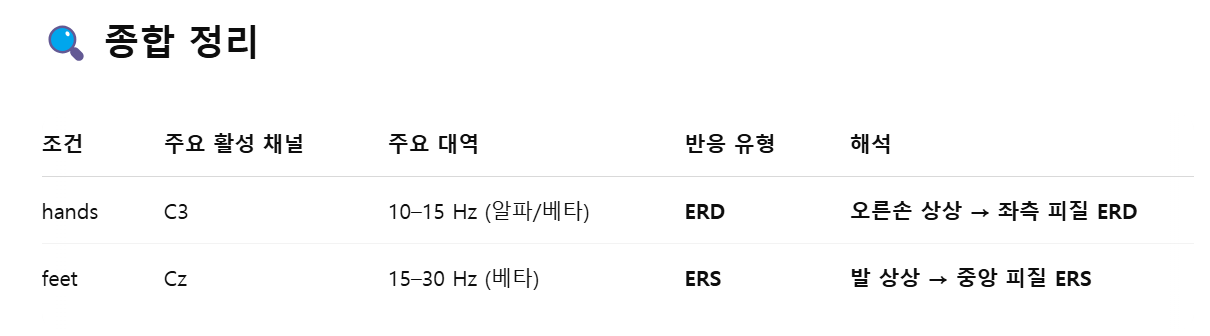

Similar to `~mne.Epochs` objects, we can also export data from
`~mne.time_frequency.EpochsTFR` and `~mne.time_frequency.AverageTFR` objects
to a :class:`Pandas DataFrame <pandas.DataFrame>`. By default, the `time`
column of the exported data frame is in milliseconds. Here, to be consistent
with the time-frequency plots, we want to keep it in seconds, which we can
achieve by setting ``time_format=None``:

- ~mne.Epochs 객체와 마찬가지로, ~mne.time_frequency.EpochsTFR 및 ~mne.time_frequency.AverageTFR 객체에서도 데이터를 pandas.DataFrame 형식으로 내보낼 수 있다.
- 기본적으로, 내보낸 데이터프레임의 time 열은 밀리초 단위(ms) 로 표시된다.
- 그러나 시간-주파수 플롯과 단위를 일치시키기 위해, 이를 초 단위(s) 로 유지하고 싶을 경우, time_format=None으로 설정하면 된다.

In [ ]:
# df = tfr.to_data_frame(time_format=None)
# tfr: mne.time_frequency.EpochsTFR 객체로, epochs.compute_tfr()로 생성된 시간-주파수 변환 결과를 담고 있음.
# .to_data_frame(): 이 메서드는 TFR 데이터를 판다스 데이터프레임 형식으로 변환해준다.
# time_format=None:
    # 기본값은 "ms"로 밀리초 단위 시간이 출력되지만,
    # None으로 설정하면 시간 값이 초(s) 단위로 변환됨.
    # 이는 앞서 시각화에서 X축이 초 단위였던 것과 일관성을 유지하기 위한 설정임.
df = tfr.to_data_frame(time_format=None)
df.head()

,time,freq,epoch,condition,C3,Cz,C4
0,-1.0000,2.0,1,feet,-0.473093,-0.474571,-0.764021
1,-0.9875,2.0,1,feet,-0.491659,-0.480088,-0.762445
2,-0.9750,2.0,1,feet,-0.500872,-0.469376,-0.749421
3,-0.9625,2.0,1,feet,-0.500605,-0.449373,-0.728686
4,-0.9500,2.0,1,feet,-0.515911,-0.443439,-0.719536


This allows us to use additional plotting functions like
:func:`seaborn.lineplot` to plot confidence bands:



#### 시간-주파수 분석 결과(TFR)를 주파수 대역별(델타~베타), 채널별(C3, Cz, C4), 조건별(hands, feet) 로 나누어 ERDS의 시간 변화를 선 그래프로 시각화하는 전체 파이프라인

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


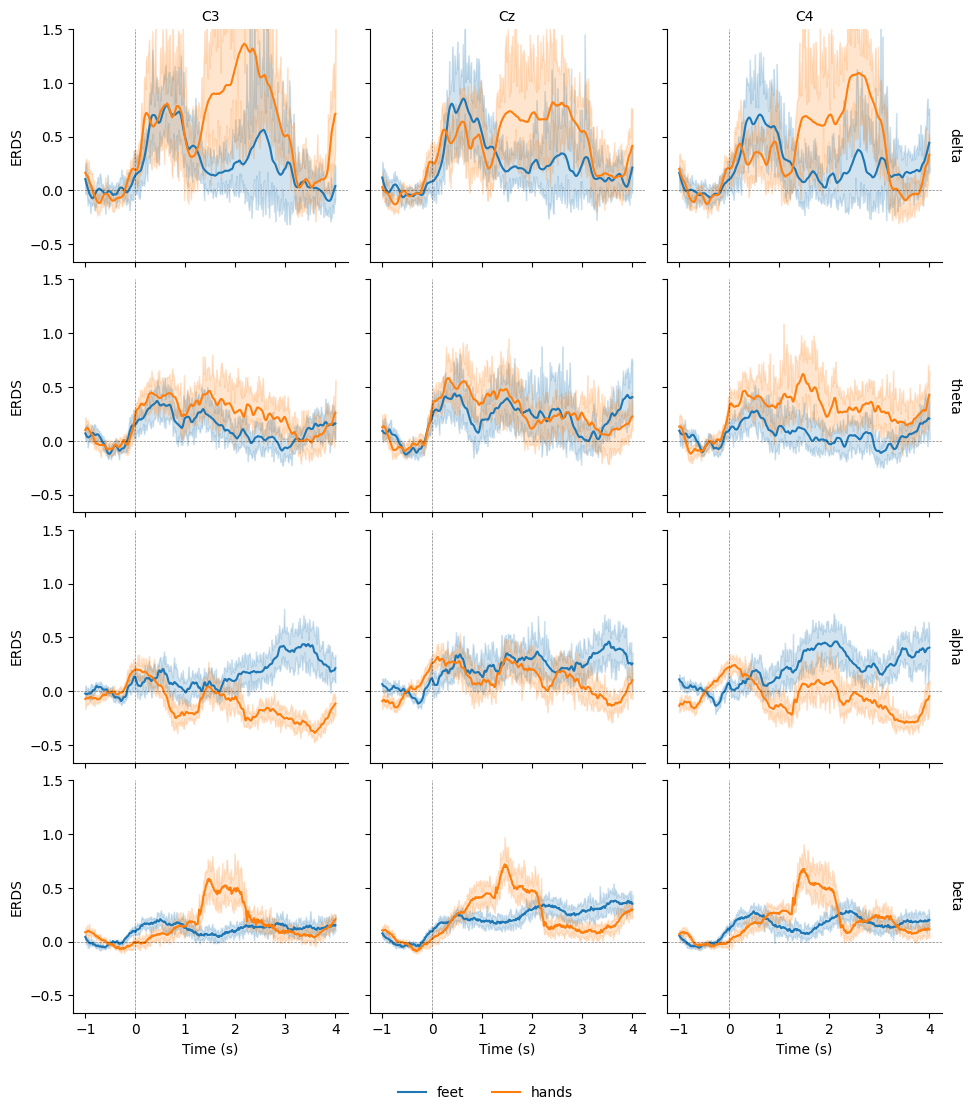

In [ ]:
# 1. TFR 데이터를 DataFrame으로 변환 (롱 포맷)
# time_format=None: 시간 단위를 **초(s)**로 설정
# long_format=True: 데이터를 long-format (tidy data)으로 정리 → 각 행이 하나의 epoch, time, freq, channel, condition, value 조합을 갖는 형태
df = tfr.to_data_frame(time_format=None, long_format=True)

# 2. 주파수 → 뇌파 밴드로 변환
# 주파수(frequency)를 다음과 같은 대역으로 분할:
# delta: 0~3 Hz
# theta: 3~7 Hz
# alpha: 7~13 Hz
# beta: 13~35 Hz
# gamma: 35~140 Hz
# pd.cut(...)은 각 주파수 값이 어떤 구간에 속하는지 판단해서 "band" 컬럼으로 저장함.
# Map to frequency bands:
freq_bounds = {"_": 0, "delta": 3, "theta": 7, "alpha": 13, "beta": 35, "gamma": 140}
df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

# 3. 관심 있는 주파수 대역만 필터링
# 분석에서 관심 있는 밴드(델타~베타)만 남김.
# 범주형(category) 값에서 사용되지 않는 라벨(gamma) 제거.
# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["delta", "theta", "alpha", "beta"]
df = df[df.band.isin(freq_bands_of_interest)]
df["band"] = df["band"].cat.remove_unused_categories()

# 4. 채널 순서 정렬
# 시각화 시 채널 순서를 "C3", "Cz", "C4" 순으로 고정.
# 이 순서대로 그래프의 열(column)이 정렬됨.
# Order channels for plotting:
df["channel"] = df["channel"].cat.reorder_categories(("C3", "Cz", "C4"), ordered=True)

# 5. Seaborn FacetGrid로 시각화 준비
g = sns.FacetGrid(df, row="band", col="channel", margin_titles=True)

# 6. 조건별 ERDS 시계열 선 그래프 그리기
g.map(sns.lineplot, "time", "value", "condition", n_boot=10)
axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)

# 7. 시각적 기준선 추가 (0초, 0 값)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)

# 8. 시각화 세부 설정
g.set(ylim=(None, 1.5))
g.set_axis_labels("Time (s)", "ERDS")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc="lower center")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

[그래프 분석]
- 각 subplot은 특정 채널-밴드 조합에서의 ERDS 시간 변화를 보여줌.
- Y축은 전력 변화율 (ERDS), X축은 자극 기준 시간 (-1초 ~ 4초).
- 0초는 운동 상상 자극 시점, 점선으로 표시됨.

[주요 해석]
- delta (0–3 Hz)
    - 전반적으로 작업 간 차이가 뚜렷하지 않음
    - hands/feet 모두 전반적으로 약간의 증가 경향 (ERS)
- theta (3–7 Hz)
    - hands 조건에서 Cz, C4 채널에서 ERS가 비교적 명확하게 보임 (1~3초 사이)
    - feet는 약간 낮은 수준이거나 유사함 → 작업 간 차이 존재 가능성
- alpha (7–13 Hz)
    - 핵심 뇌파 대역 중 하나로 의미 있는 차이 발생
- -> 정리
    - C3: hands에서 alpha ERD 발생 (전력 감소) → 운동 상상 시 sensorimotor 억제 반응
    - Cz: feet 조건에서 ERS, hands에서는 ERD → feet가 Cz 중심 활성화 유도
    - C4: hands 조건에서 ERD 약하게 관찰됨, feet는 상대적으로 안정적

- beta (13–35 Hz)
    - 또 하나의 주요 운동 관련 대역
-  -> 정리
    - C3: hands 조건에서 1~2.5초 사이 강한 ERD 발생 → 오른손 상상 시 좌측 피질 억제
    - Cz: feet 조건에서 ERS 보임 → 양발 상상 시 중앙 피질 활성화와 일치
    - C4: feet 조건은 상대적으로 높고, hands는 약한 ERD

[결론]
- alpha, beta 대역은 motor imagery 조건을 구분하기에 가장 유용함
- 채널별 반응 차이는 신체 부위별 운동 피질의 위치 차이를 잘 반영함
- 이 결과는 모터 이미저리 기반 BCI 시스템의 피처 선택/채널 선택에 직접 활용 가능함

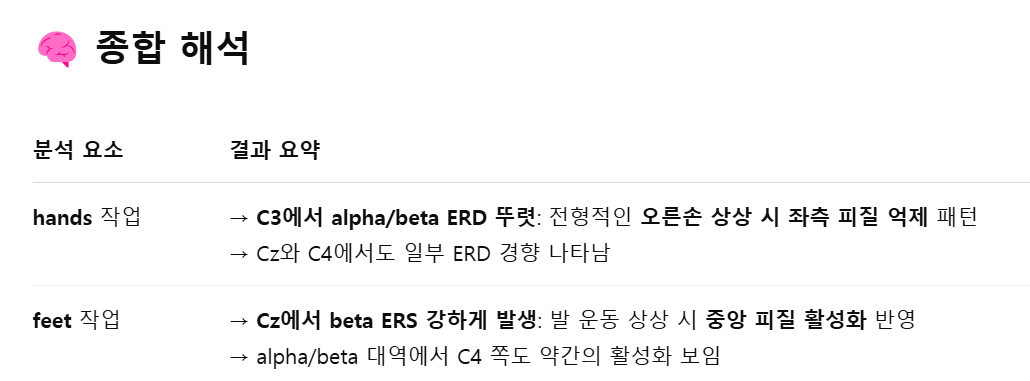

Having the data as a DataFrame also facilitates subsetting,
grouping, and other transforms.
Here, we use seaborn to plot the average ERDS in the motor imagery interval
as a function of frequency band and imagery condition:

- 데이터를 DataFrame 형태로 가지고 있으면, **서브셋 추출, 그룹화, 기타 변환 작업**을 훨씬 쉽게 수행할 수 있다.
- 여기서는 **Seaborn** 라이브러리를 사용하여, **운동 상상(motor imagery)** 구간 동안의 평균 ERDS를 **주파수 밴드와 상상 조건**에 따라 시각화한다.

#### motor imagery 자극 이후(1초 이후)의 ERDS 값을 조건별로 평균화하고, 이를 violin plot 형태로 주파수 밴드, 채널, 조건(hands vs feet) 별로 시각화하는 전체 흐름

/Users/kyunghowon/anaconda3/envs/GENESIS/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/kyunghowon/anaconda3/envs/GENESIS/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


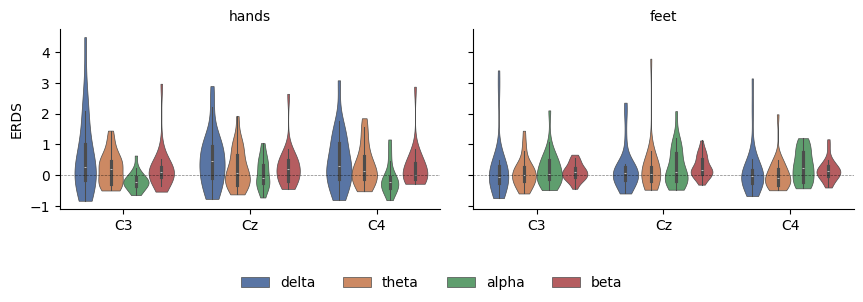

In [ ]:
# 1. 자극 이후 구간(>1s)의 평균 ERDS 계산
df_mean = (
    df.query("time > 1") # 운동 상상 자극 이후(1초 이후)의 데이터만 필터링
    .groupby(["condition", "epoch", "band", "channel"], observed=False)[["value"]]  # 각 조건별(hands / feet), 에포크별, 주파수 밴드별, 채널별로 그룹화
    .mean() # 그룹마다 value (ERDS 값)의 평균을 계산
    .reset_index()  # groupby 결과를 DataFrame으로 다시 정리
)

# 2. Violin Plot용 FacetGrid 설정
# 조건(hands, feet)별로 두 개의 열(column)을 갖는 FacetGrid 생성
# 각 subplot은 하나의 상상 조건에 해당함
g = sns.FacetGrid(
    df_mean, col="condition", col_order=["hands", "feet"], margin_titles=True
)

# 3. Violin Plot 시각화
g = g.map(
    sns.violinplot,
    "channel",
    "value",
    "band",
    cut=0,
    palette="deep",
    order=["C3", "Cz", "C4"],
    hue_order=freq_bands_of_interest,
    linewidth=0.5,
).add_legend(ncol=4, loc="lower center")

g.map(plt.axhline, **axline_kw)
g.set_axis_labels("", "ERDS")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)

[그래프 분석]: Violin plot은 motor imagery 실험에서 자극 이후(1초 이후) 구간의 ERDS 분포를 시각화한 것
- 조건(hands, feet), 채널(C3, Cz, C4), 주파수 밴드(delta, theta, alpha, beta)에 따라 나누어 분포 형태, 중앙값, 밀도를 비교할 수 있다.

[해석 포인트]
- ERDS 값의 해석
    - 0보다 작음 (하단으로 퍼짐) → ERD: 전력 감소 → 기능적 억제
    - 0보다 큼 (상단으로 퍼짐) → ERS: 전력 증가 → 기능적 활성화
    - Violin plot이 두껍게 퍼진 곳 → 많은 데이터가 집중된 영역

[hands 조건]
- delta: 넓고 긴 분포, ERS 중심값 뚜렷 (많이 퍼져 있음)
- alpha, beta: 평균적으로 0 아래쪽에 분포 → 손 상상 시 sensorimotor 억제(ERD) 반영 | Cz |
- 전반적으로 delta, theta가 높고 넓음 (ERS)
- alpha, beta는 억제 반응 혼재 | C4 |
- 전반적으로 all bands에서 ERS 기울기 높음, 특히 theta와 delta
- hands 조건에서도 C4가 활성화되는 경향 존재
- 요약: hands 조건에서는 C3의 alpha/beta ERD가 비교적 뚜렷 → 오른손 상상에 대한 좌측 피질 반응 반영

[feet 조건]
- delta, theta, alpha 등 여러 밴드에서 높고 넓은 ERS → 발 상상 시 Cz 중심 활성화 | C4 |
- alpha 대역은 양쪽에서 유사하게 분포됨
- delta, beta 등도 Cz보다는 좁지만 여전히 ERS 기울기 있음
- 요약: feet 조건에서는 Cz의 delta/theta ERS가 강하게 나타나며, 이는 발 상상 시 중심 피질 활성화 특성과 일치

[결론]
- hands 조건: 좌측 피질(C3) 에서 고주파(α/β) 억제 → 운동 상상에 따른 기능 억제
- feet 조건: 중심 피질(Cz) 에서 저주파(δ/θ) 활성화 → 발 상상 시 기능적 활성화

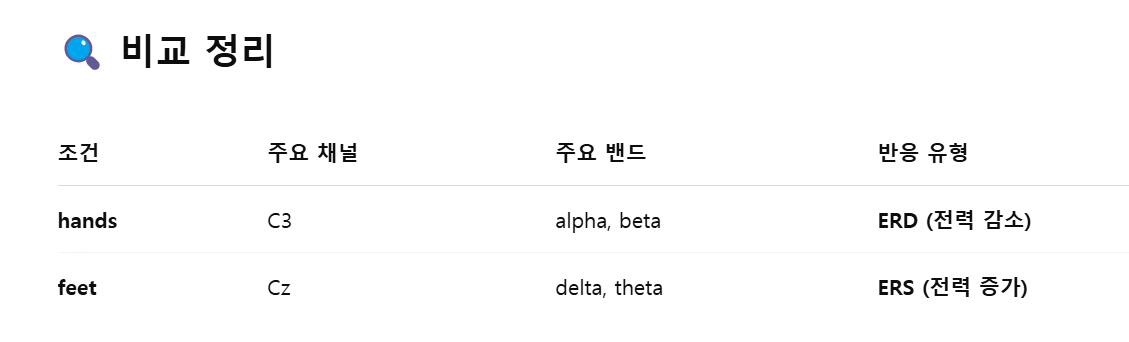